<a href="https://colab.research.google.com/github/LeslyJaramillo/INTELIGENCIA-ARTIFICIAL/blob/main/DEEPFAKE_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRUEBA UNO**

Esta primera prueba se hizo en base a redes neuronales convolucionales.

# IMPORTAR LIBRERIAS

In [ ]:
!pip install tensorflow keras opencv-python

In [ ]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import HTML, Javascript

# CARGAR IMAGENES

En esta sección el codigo sube imágenes en formato .jpg desde el sistema de archivos del usuario. Luego, carga estas imágenes en memoria, redimensiona las dos primeras a un tamaño de 256x256 píxeles y normaliza sus valores de píxeles para que estén en el rango [0, 1]. Finalmente, agrega una dimensión adicional a cada imagen para que su forma sea compatible con los modelos de aprendizaje automático que requieren entradas en formato de lote (batch).

In [ ]:
# Subir las imágenes
uploaded = files.upload()

# Cargar las imágenes
imgs = []
for filename, filedata in uploaded.items():
    if filename.endswith('.jpg'):
        img = cv2.imdecode(np.frombuffer(filedata, np.uint8), cv2.IMREAD_COLOR)
        imgs.append(img)

# Redimensionar las imágenes a un tamaño adecuado
img1 = cv2.resize(imgs[0], (256, 256))
img2 = cv2.resize(imgs[1], (256, 256))

# Normalizar las imágenes
img1 = img1 / 255.0
img2 = img2 / 255.0

# Agregar una dimensión a la entrada
img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)

# MODELO DEEPFAKE

En esta sección el código construye y entrena un modelo de red neuronal convolucional para generar imágenes deepfake. El modelo, definido como una secuencia de capas convolucionales en Keras, transforma una imagen de entrada de tamaño 256x256 con 3 canales (RGB) en otra imagen de igual tamaño, aplicando varias capas convolucionales con activaciones ReLU y una capa final con activación tanh. Después de construir el modelo, se compila usando el optimizador Adam y la función de pérdida de error cuadrático medio (mean squared error). Luego, el modelo se entrena usando una imagen de entrada (img1) y su correspondiente imagen objetivo (img2) durante 100 épocas. Finalmente, el modelo realiza predicciones sobre la imagen de entrada para generar una imagen transformada.

In [ ]:
# Construir el modelo de deepfake
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(3, (3, 3), activation='tanh', padding='same')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(img1, img2, epochs=100)

# Hacer predicciones
predicted_img = model.predict(img1)

# GRAFICOS


En esta sección del codigo se relizan todas las configuraciones para mosntrar el resulatado.



In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1[0])
plt.title('Imagen original 1')

plt.subplot(1, 3, 2)
plt.imshow(img2[0])
plt.title('Imagen original 2')

plt.subplot(1, 3, 3)
plt.imshow(predicted_img[0])
plt.title('Resultado de deepfake')

plt.show()

# **PRUEBA DOS**

# IMPORTAR LIBRERIAS

In [ ]:
# Instalar las librerías necesarias
!pip install dlib opencv-python

# Descargar el predictor de puntos faciales y descomprimirlo
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

import cv2
import dlib
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# MODELO

En esta sección el código carga un detector de caras y un predictor de puntos faciales usando la biblioteca dlib. Define dos funciones: extract_landmarks, que extrae los puntos faciales de una imagen usando estos modelos, y swap_faces, que intercambia las facciones entre dos imágenes. La función swap_faces detecta y extrae las regiones faciales de ambas imágenes, calcula una transformación afín para alinear las facciones de una imagen con la otra, aplica esta transformación a la región facial, y finalmente intercambia las caras entre las dos imágenes. El resultado es una imagen en la que las facciones faciales de una imagen han sido transferidas a la otra y viceversa.

In [ ]:
# Cargar el detector de caras y el predictor de puntos faciales
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Función para extraer puntos faciales
def extract_landmarks(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    landmarks = predictor(gray, faces[0])
    return np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)])

# Función para intercambiar facciones faciales
def swap_faces(img1, img2):
    landmarks1 = extract_landmarks(img1)
    landmarks2 = extract_landmarks(img2)

    if landmarks1 is None or landmarks2 is None:
        print("No se detectaron puntos faciales en una de las imágenes.")
        return None, None

    # Obtener la región facial en cada imagen
    hull1 = cv2.convexHull(landmarks1)
    hull2 = cv2.convexHull(landmarks2)

    mask1 = np.zeros_like(img1, dtype=np.uint8)
    cv2.fillConvexPoly(mask1, hull1, (255, 255, 255))

    mask2 = np.zeros_like(img2, dtype=np.uint8)
    cv2.fillConvexPoly(mask2, hull2, (255, 255, 255))

    face_region1 = cv2.bitwise_and(img1, mask1)
    face_region2 = cv2.bitwise_and(img2, mask2)

    # Obtener la transformación para ajustar las facciones
    points1 = landmarks1[np.array([36, 45, 30])]  # Usamos más puntos para la transformación
    points2 = landmarks2[np.array([36, 45, 30])]
    M = cv2.getAffineTransform(np.float32(points2), np.float32(points1))

    # Transformar la región facial
    h, w = img1.shape[:2]
    transformed_face2 = cv2.warpAffine(face_region2, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    # Intercambiar caras
    final_image1 = cv2.bitwise_and(transformed_face2, mask1)
    final_image2 = cv2.bitwise_and(face_region1, mask2)

    swapped_img1 = cv2.add(final_image1, cv2.subtract(img1, face_region1))
    swapped_img2 = cv2.add(final_image2, cv2.subtract(img2, face_region2))

    return swapped_img1, swapped_img2


# RESULTADO DEL MODELO


En esta sección se intercambia las caras entre dos imágenes utilizando técnicas de visión por computadora. Primero, carga un detector de caras y un predictor de puntos faciales para identificar y mapear características faciales en las imágenes. Luego, extrae los puntos faciales y crea máscaras para las regiones faciales en ambas imágenes. Utiliza una transformación afín para alinear y adaptar las facciones faciales de una imagen a la otra, y finalmente combina las regiones faciales transformadas para producir dos imágenes con las caras intercambiadas

--2024-08-14 23:05:26--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  22.4MB/s    in 2.7s    

2024-08-14 23:05:29 (22.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



Saving imagen_A1.jpg to imagen_A1.jpg
Saving imagen_A11.jpg to imagen_A11.jpg


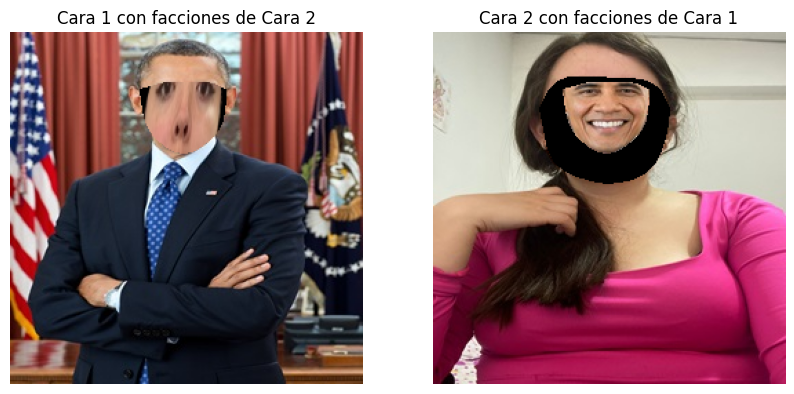

In [ ]:

# Subir las imágenes
uploaded = files.upload()

# Tomar los dos primeros archivos subidos para el intercambio de facciones
images = list(uploaded.keys())
if len(images) < 2:
    print("Por favor, sube al menos dos imágenes.")
else:
    img1_path = images[0]
    img2_path = images[1]

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Realizar el intercambio de facciones
    swapped_img1, swapped_img2 = swap_faces(img1, img2)

    if swapped_img1 is not None and swapped_img2 is not None:
        # Mostrar las imágenes resultantes
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(cv2.cvtColor(swapped_img1, cv2.COLOR_BGR2RGB))
        axs[0].axis('off')
        axs[0].set_title('Cara 1 con facciones de Cara 2')
        axs[1].imshow(cv2.cvtColor(swapped_img2, cv2.COLOR_BGR2RGB))
        axs[1].axis('off')
        axs[1].set_title('Cara 2 con facciones de Cara 1')
        plt.show()
    else:
        print("No se pudo realizar el intercambio de facciones.")


En las dos pruebas no se logro llegar al obejetivo de hacer deepfake, la segunda pruba despues de varias pruebas fue las mas cercana pero necesita aun muchos ajustes.